In [175]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from time import time_ns
import numpy as np
from math import cos, pi
import seaborn as sns
sns.set()
%matplotlib inline

In [273]:
device = torch.device("cpu")

In [332]:
words = open("names.txt", "r").read().splitlines()
words[:8]
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i, s in enumerate(["."]+chars)}
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

block_size = 16 # context length

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X).to(device)
    Y = torch.tensor(Y).to(device)
    print(X.shape, Y.shape)
    return X.to(device), Y.to(device)

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])   # training
Xdev, Ydev = build_dataset(words[n1:n2]) # dev
Xte,  Yte  = build_dataset(words[n2:])   # test

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27
torch.Size([182625, 16]) torch.Size([182625])
torch.Size([22655, 16]) torch.Size([22655])
torch.Size([22866, 16]) torch.Size([22866])


In [333]:
np.mean(np.array([len(x) for x in words]))

np.float64(6.122217712983486)

In [334]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = (torch.randn((fan_in, fan_out)) / fan_in**0.5).to(device) # kaiming init
        self.bias = torch.zeros(fan_out).to(device) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params
        self.gamma = torch.ones(dim).to(device)
        self.beta = torch.zeros(dim).to(device)
        # buffers (trained w/ running "momentum update")
        self.running_mean = torch.zeros(dim).to(device)
        self.running_var = torch.ones(dim).to(device)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to Zscore
        self.out = self.gamma * xhat + self.beta # Zscore output linearity
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    (1 - self.momentum) * self.running_mean + 
                    self.momentum * xmean
                )
                self.running_var = (
                    (1 - self.momentum) * self.running_var +
                    self.momentum * xvar
                )

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x).to(device)
        return self.out

    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim)).to(device)
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, (C * self.n)) # n = number of consec vectors to flatten

        if x.shape[1] == 1:
            # remove unnecessary dimension
            x = x.squeeze(1)
            
        self.out = x
        return self.out
        
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [343]:
torch.manual_seed(42)

In [344]:
n_embd = 24 # dim of embedding
n_hidden = 128 # n neurons

activation_count = torch.zeros(4, n_hidden).to(device)

model = Sequential([
    # (n, block_size, vocab_size) -> (n, block_size, n_embd)
    Embedding(vocab_size, n_embd), 
    # (n, block_size, n_embd) -> (n, block_size/2, n_embd*2) -> (n, block_size/2, n_hidden)
    # this layer has #n_hidden neurons
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # 2
    # (n, block_size/2, n_hidden) -> (n, block_size/4, n_hidden*2) -> (n, block_size/4, n_hidden)
    # also #n_hidden neurons
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # 4
    # (n, block_size/4, n_hidden) -> (n, block_size/8, n_hidden*2) -> (n, block_size/8, n_hidden)
    # also #n_hidden neurons
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # 4
    # (n, block_size/8, n_hidden) -> (n, block_size/16=1, n_hidden) -> (n, n_hidden)
    # also #n_hidden neurons
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # 8
    # (n, n_hidden) -> (n, vocab_size)
    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # make the last layer less confident so it's not confidently wrong

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

109603


In [345]:
### same optimization
max_steps = 200_000
batch_size = 32
lossi = []

etimes = []

for i in range(max_steps):
    ts = time_ns()

    # build minibatch    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)).to(device)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update SGD
    lr = 0.1 if i < 150_000 else 0.01 # decay
    # cosine learning rates?!
    lr *= cos((2*pi)/10_000) + 1 + 1e-3
    for p in parameters:
        p.data += -lr * p.grad

    te = time_ns()
    
    etimes.append(te - ts)

    # stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}. avg epoch time = {np.array(etimes).mean()/1e9:.6f}s')
    lossi.append(loss.log10().item())

    # visualize activations
    with torch.no_grad():
        for i, layer in enumerate(layer for layer in model.layers if layer.__class__.__name__ == "Tanh"):
            ax = 0 if i == 3 else (0, 1)
            activation_count[i] += torch.sum((layer.out > 0.9), axis=ax)

      0/ 200000: 3.2724. avg epoch time = 0.002659s
  10000/ 200000: 2.1209. avg epoch time = 0.001715s
  20000/ 200000: 2.4742. avg epoch time = 0.001593s
  30000/ 200000: 1.7305. avg epoch time = 0.001543s
  40000/ 200000: 1.8206. avg epoch time = 0.001519s
  50000/ 200000: 2.1505. avg epoch time = 0.001501s
  60000/ 200000: 1.8123. avg epoch time = 0.001492s
  70000/ 200000: 1.7788. avg epoch time = 0.001484s
  80000/ 200000: 2.0025. avg epoch time = 0.001479s
  90000/ 200000: 2.0058. avg epoch time = 0.001475s
 100000/ 200000: 1.8954. avg epoch time = 0.001505s
 110000/ 200000: 2.0828. avg epoch time = 0.001520s
 120000/ 200000: 1.7360. avg epoch time = 0.001535s
 130000/ 200000: 1.7629. avg epoch time = 0.001540s
 140000/ 200000: 1.8653. avg epoch time = 0.001551s
 150000/ 200000: 1.7084. avg epoch time = 0.001547s
 160000/ 200000: 1.6417. avg epoch time = 0.001538s
 170000/ 200000: 1.5949. avg epoch time = 0.001530s
 180000/ 200000: 1.6645. avg epoch time = 0.001525s
 190000/ 200

In [355]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (1, 16, 24)
FlattenConsecutive : (1, 8, 48)
Linear : (1, 8, 128)
BatchNorm1d : (1, 8, 128)
Tanh : (1, 8, 128)
FlattenConsecutive : (1, 4, 256)
Linear : (1, 4, 128)
BatchNorm1d : (1, 4, 128)
Tanh : (1, 4, 128)
FlattenConsecutive : (1, 2, 256)
Linear : (1, 2, 128)
BatchNorm1d : (1, 2, 128)
Tanh : (1, 2, 128)
FlattenConsecutive : (1, 256)
Linear : (1, 128)
BatchNorm1d : (1, 128)
Tanh : (1, 128)
Linear : (1, 27)


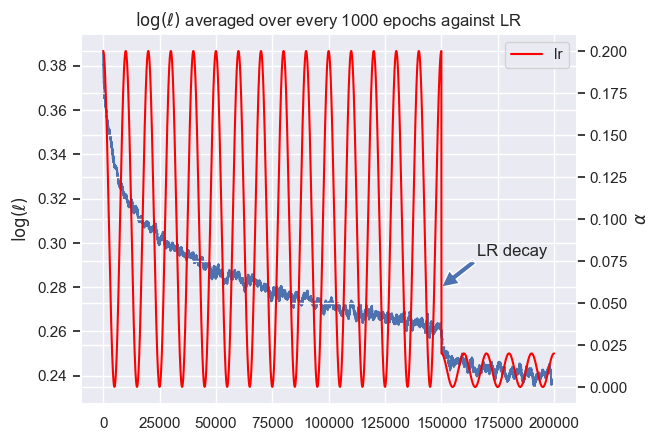

In [347]:
# running avg the losses
window = 1_000
loss_np = np.array(lossi)
loss_avg = np.convolve(loss_np, np.ones(window)/window, mode='valid')

plt.subplots()
plt.title(r"$\log(\ell)$ averaged over every 1000 epochs against LR");
plt.plot(loss_avg, label='loss')
plt.annotate("LR decay", xy=(150_000, 0.28), xycoords='data', xytext=(.8, .4), textcoords='axes fraction', arrowprops=dict());
plt.ylabel(r"$\log(\ell)$")

ax2 = plt.twinx()
lrs = np.ones(200_000) * 0.1
lrs[150_000:] = 0.01
lrs *= np.cos((2*np.pi/10_000) * np.arange(0, 200_000))+1+1e-3
ax2.plot(lrs, color='red', label='lr')
ax2.set_ylabel(r"$\alpha$")

ax2.legend()

In [348]:
# eval mode
for layer in model.layers:
    layer.training = False

In [358]:
# eval loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train' : (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7210533618927002
val 2.0291948318481445


In [367]:
# sample from the model
print('sampling from model:')
for _ in range(20):
    out = []
    context = [0] * block_size # null init
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample: this is where nondeterminism comes from!
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift ctx window
        context = context[1:] + [ix]
        out.append(ix)
        # if sampled null, break
        if ix == 0:
            break

    print('\t',''.join(itos[i] for i in out))
    

sampling from model:
	 keylee.
	 delaine.
	 baddia.
	 jadyn.
	 hadley.
	 cristawanna.
	 jamiya.
	 aceil.
	 speya.
	 jaicee.
	 kacelin.
	 annabek.
	 jaxsten.
	 jadisa.
	 presean.
	 gralynn.
	 bocksro.
	 xinice.
	 kenid.
	 mehas.


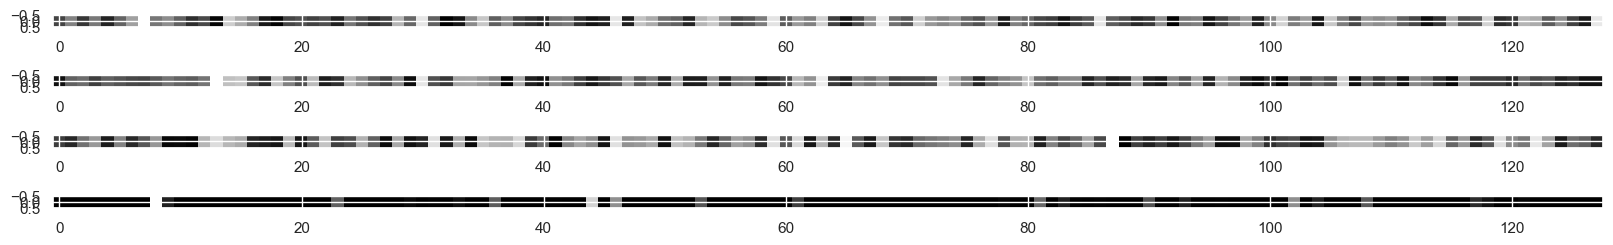

In [356]:
plt.figure(figsize=(20, 3))
for i in range(4):
    plt.subplot(4, 1, i + 1)
    plt.imshow((activation_count[i]/len(lossi)).cpu().view(1, -1), cmap='gray')

In [352]:
def sample(X, n = 100):
    return X
    idxs = torch.randint(0, X.shape[0], (n,))
    return X[idxs]

torch.Size([128, 181240])
torch.Size([128, 90620])
torch.Size([128, 45310])
torch.Size([128, 22655])


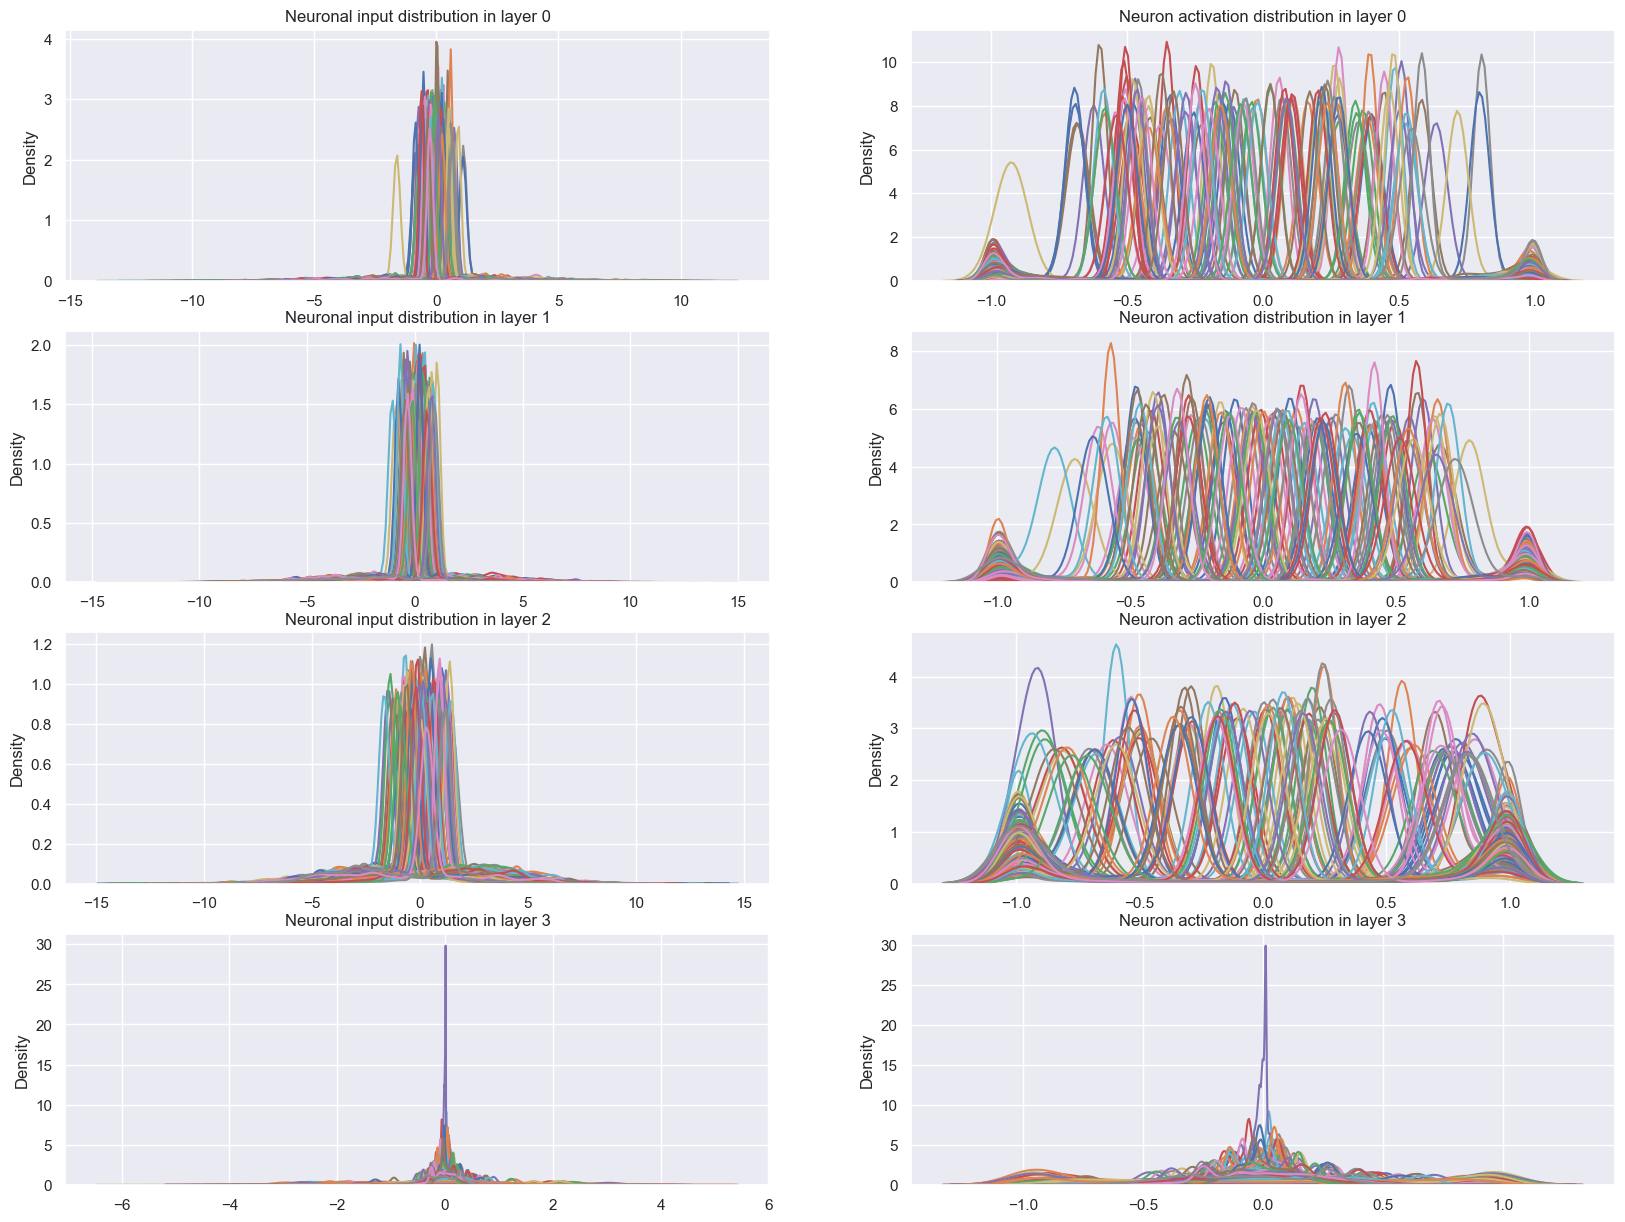

In [359]:
plt.figure(figsize=(20, 15))
for i, layer in enumerate(layer for layer in model.layers if layer.__class__.__name__ == "BatchNorm1d"):
    view = layer.out.detach().view(-1, n_hidden).T
    plt.subplot(4, 2, 2*i + 1)
    plt.title(f"Neuronal input distribution in layer {i}")
    [sns.kdeplot(sample(view[i, :])) for i in range(n_hidden)]
    plt.subplot(4, 2, 2*i + 2)
    plt.title(f"Neuron activation distribution in layer {i}")
    [sns.kdeplot(F.tanh(sample(view[i, :]))) for i in range(n_hidden)]
    print(view.shape)

In [360]:
model.layers[4]

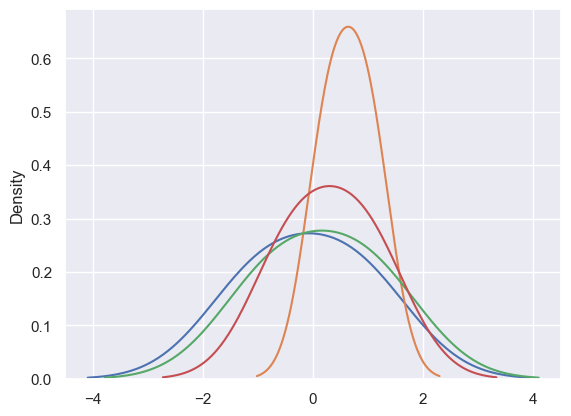

In [370]:
#i = 90
view = model.layers[12].out.detach().view(-1, n_hidden).T
[sns.kdeplot(view[i, :]) for i in list(range(n_hidden))[::40]];

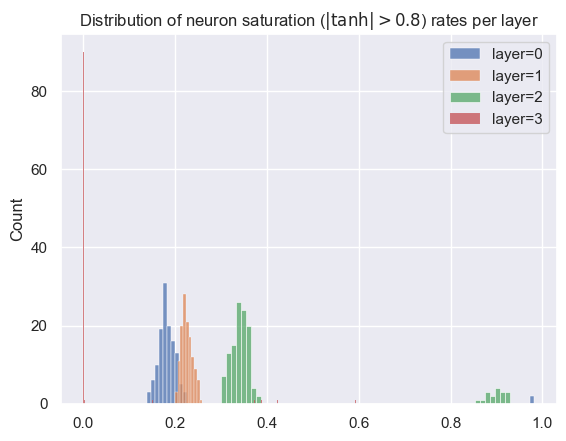

In [363]:
# try to calculate saturation rates
plt.title(r"Distribution of neuron saturation ($|\tanh| > 0.8$) rates per layer")
for layer in range(4):
#layer = 0
    n = model.layers[4 + layer*4].out.view(-1, n_hidden).shape[0]
    sns.histplot((model.layers[4 + layer*4].out.view(-1, n_hidden).abs() > 0.8).sum(dim=0) / n, label=f"layer={layer}")
plt.legend();